In [76]:
import os
import torch
import data
import utils
from scipy.interpolate import interp1d
import config as cfg
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from xpbd_softbody_layer import XPBDStep
import pyvista as pv
import matplotlib.pyplot as plt
from xpbd_softbody import XPBDSoftbody

torch.Size([600, 3])
torch.Size([1200, 3])


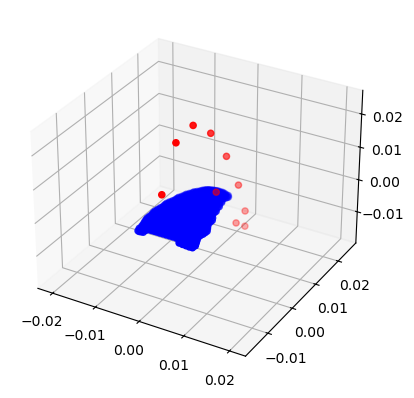

In [77]:
mesh, softbody = data.get_xpbd_grape()

# Hardcoded control trajectory
control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
                               [ 0.0023,  0.0192, -0.0120],
                               [ 0.0005,  0.0080,  0.0185],
                               [-0.0009, -0.0084,  0.0104]])

# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), 10)  # 10 times denser
f = interp1d(x, control_trajectory, axis=0, kind='cubic')
control_trajectory = f(xnew)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(control_trajectory[:, 0], control_trajectory[:, 1], control_trajectory[:, 2], c='r', marker='o')
ax.scatter(mesh.points[:, 0], mesh.points[:, 1], mesh.points[:, 2], c='b', marker='o')
utils.axisEqual3D(ax)
plt.show()

In [78]:
control_trajectory = torch.from_numpy(control_trajectory).to(cfg.device)
softbody.init_grasp_constraints(loc=deepcopy(control_trajectory[0]), radius=1e-3)


cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

control point connects to 8 vertices


In [79]:
def get_energy_boundary(softbody: XPBDSoftbody,
                         V_predict: torch.Tensor,
                         V_boundary_stiffness: torch.Tensor,
                         mask: set = None) -> torch.Tensor:
    
    V_boundary_stiffness_threshold = V_boundary_stiffness.clone()
    V_boundary_stiffness_threshold[V_boundary_stiffness_threshold < 1e-3] = 0
    # V_boundary_stiffness_threshold = V_boundary_stiffness_threshold * torch.sigmoid(V_boundary_stiffness_threshold - 1e-3)


    dist_C, dist_C_stiffness = __get_spring_boundary_constraints(softbody,
                                                      V_predict,
                                                      V_boundary_stiffness_threshold,
                                                      mask)
    # energy is C^2 * stiffness / 2
    boundary_energy = torch.square(dist_C) * dist_C_stiffness / 2
    return boundary_energy

def __get_spring_boundary_constraints(softbody, V_predict, V_boundary_stiffness, mask=None):
    C = []
    C_stiffness = []
    # collect all distance constraints
    for C_dist, C_init_d in zip(softbody.C_boundary_list, softbody.C_init_boundary_d_list):
        if mask == None or (C_dist[:, 0] in mask and C_dist[:, 1] in mask):
            # position difference vectors
            N = V_predict[C_dist[:, 0]] - V_predict[C_dist[:, 1]]
            # distance
            D = torch.norm(N, p=2, dim=1, keepdim=True)
            # constarint values
            C.append(D - C_init_d)
            # average stiffness
            C_stiffness.append(V_boundary_stiffness[C_dist[:, 0]])
    return torch.cat(C), torch.cat(C_stiffness)


In [80]:
energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)

In [81]:
energy.shape

torch.Size([600, 1])

In [82]:
color = list(energy.cpu().numpy())

In [83]:
pv.set_plot_theme('document')
pl = pv.Plotter()

# skin being peeled
mesh_actor = pl.add_mesh(mesh, scalars=color, cmap='jet', show_edges=True, edge_color='#b37164ff', lighting=False, style='surface')

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


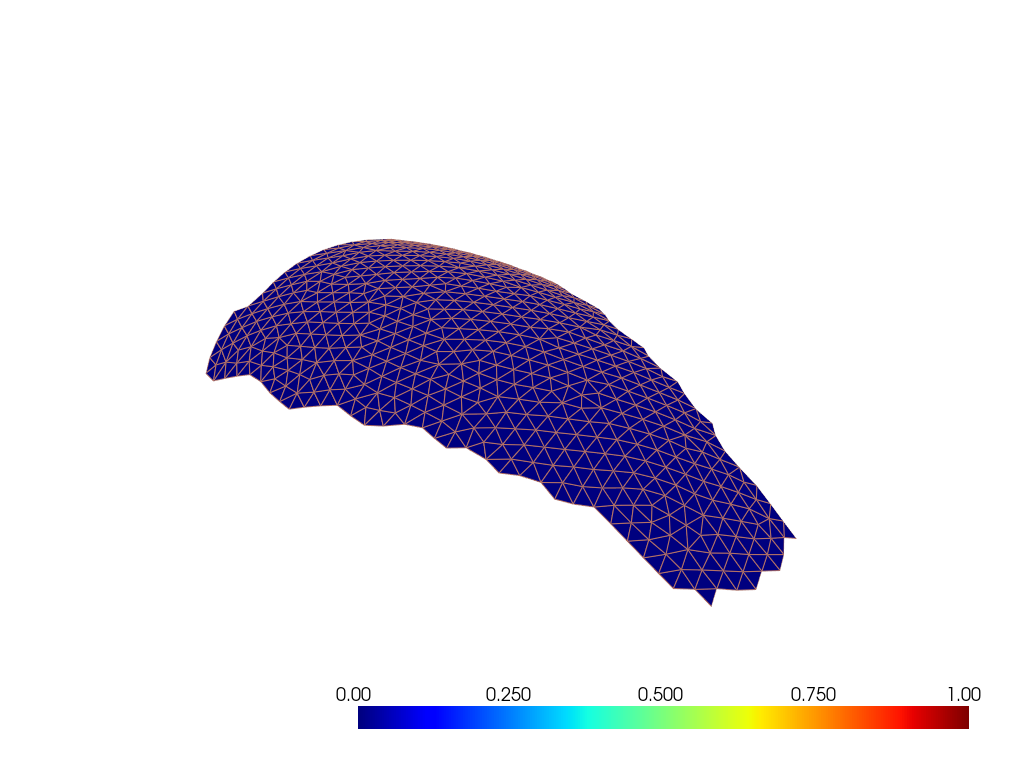

In [84]:
pl.show()